# Metropolis Hastings for Bayesian inference of the parameters of IID Poisson distributed samples

Samples are assumed to be drawn from a Poisson distribution where the mean of the distribution is drawn from a (continuous) uniform distribution.

The mean of the Poisson distribution is

$$
\lambda \sim \text{Uniform}(a,b)
$$

where $a < b$. The probability density function $p(\lambda)$ can be written

$$
p(\lambda) = 
\begin{cases}
 \frac{1}{b-a} & a \leq \lambda \leq b \\
 0             & \text{otherwise} \\
\end{cases}
$$

The log of the PDF of the Poisson distribution $p(\lambda)$ is given by

$$
\begin{align}
\ln p(\lambda) &= \ln \frac{1}{b-a} \\
               &= \ln 1 - \ln (b-a)  \\
               &= - \ln (b-a). \\
\end{align}
$$

for $a < b$. 

The samples that are assumed to be independent and identically distributed (IID) are drawn from a Poisson distribution. A single sample is distributed as

$$
x_i \sim \text{Poisson}(x_i; \lambda)
$$

and the probability of the samples is given by

$$
p(x | \lambda) = \prod_{i=0}^{N-1} p(x_i | \lambda).
$$

The $p(x_i | \lambda)$ is given by

$$
p(x | \lambda) = e^{-\lambda} \frac{\lambda}{x!}
$$

The natural log of the PDF for the Poisson distribution is given by

$$
\begin{align}
\ln p(x | \lambda) &= \ln \big( e^{-\lambda} \frac{\lambda}{x!} \big) \\
&= \ln \big( e^{-\lambda} \big) + \ln \Big( \frac{\lambda^x}{x!} \Big) \\
&= -\lambda + \ln \lambda^x - \ln x! \\
&= -\lambda + x \ln \lambda - \ln x! \\
&= x \ln \lambda -\lambda - \ln x! \\
\end{align}
$$
From Bayes' theorem

$$
\begin{align}
p(\lambda | x) &= \frac{p(x | \lambda) p(\lambda)}{p(x)} \\
               &\propto p(x | \lambda) p(\lambda) \\
               &= \Big( \prod_{i=0}^{N-1} p(x_i | \lambda) \Big) p(\lambda)
\end{align}
$$

The natural logarithm of the posterior distribution is given by

$$
\begin{align}
\ln p(\lambda | x) &\propto \ln \prod_{i=0}^{N-1} p(x_i | \lambda) - \ln p(\lambda) \\ 
 &= \sum_{i=0}^{N-1} \ln p(x_i | \lambda) - \ln p(\lambda)  \\
 &= \sum_{i=0}^{N-1} \Big( x_i \ln \lambda - \lambda - \ln x_i! \Big) - \ln (b-a) \\
 &= \sum_{i=0}^{N-1} \Big( x_i \ln \lambda - \ln x_i! \Big) - N \lambda - \ln (b-a) \\
 &\propto \sum_{i=0}^{N-1} \Big( x_i \ln \lambda \Big) - N \lambda
\end{align}
$$

This is because $\sum_{i=0}^{N-1} \ln x_i!$ is a constant, irrespective of $\lambda$, as is $\ln (b-a)$. Therefore,

$$
p(\lambda | x) \propto \exp \left\{ \sum_{i=0}^{N-1} \Big( x_i \ln \lambda \Big) - N \lambda \right\}
$$

This probability distribution is not of a known closed form, thus there isn't a straightforward way to generate samples.

## Metropolis-Hastings

Stochastic simulation is a random experiment that mimics a complex system that is too difficult to deal with.

The Metropolis-Hastings algorithm simulates samples from a probability distribution and uses the full joint density and independent proposal distributions.

The algorithm for a full joint density $\pi(\cdot)$ and a symmetric proposal function $q(\cdot)$ is as follows:

> Initialise $x^{(0)} \sim q(x)$  
> for iteration $1, 2, \dots, M$ do  
$\quad$ Propose $x^{\text{cand}} \sim q(x^{(i)} | x^{(i-1)}) $  
$\quad$ Acceptance probability $\alpha(x^{\text{cand}} | x^{(i-1)}) = \min \left\{ 1, \frac{\pi(x^{\text{cand}})}{\pi(x^{(i-1)})} \right\} $  
$\quad u \sim \text{Uniform}(u; 0, 1)$  
$\quad$if $u < \alpha$ then  
$\qquad$Accept the proposal: $x^{(i)} \leftarrow x^{\text{cand}}$  
$\quad$else  
$\qquad$Reject the proposal: $x^{(i)} \leftarrow x^{(i-1)}$  
$\quad$end if  
>end for  

### Generate the samples

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
a = 0.1
b = 5
lambda_actual = np.random.uniform(a, b)
print(f"Actual lambda = {lambda_actual}")

Actual lambda = 3.285418054723508


In [3]:
# Number of samples
N = 50

# Generate the N samples from the Poisson distribution
x = np.random.poisson(lambda_actual, N)

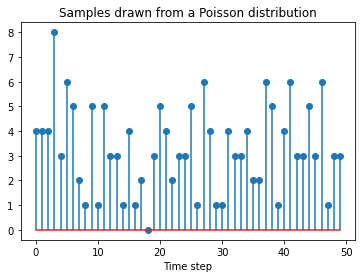

In [4]:
plt.stem(x)
plt.title('Samples drawn from a Poisson distribution')
plt.xlabel('Time step')
plt.show()

In [5]:
def p_lambda_given_x(x, lam, a, b):
    
    N = len(x)
    
    if a <= lam <= b:
        ln_p = np.sum(np.log(lam) * x) - N*lam
        p = np.exp(ln_p)        
    else:
        p = 0.0

    return p

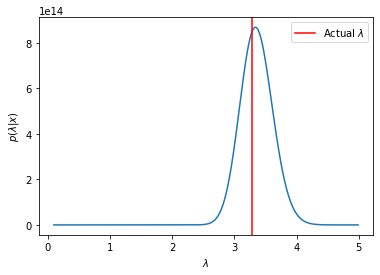

In [6]:
lam_candidates = np.arange(a, b, 0.01)
p = [p_lambda_given_x(x, lam, a, b) for lam in lam_candidates]

plt.plot(lam_candidates, p)
plt.axvline(x=lambda_actual, color='r', label='Actual $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('$p(\lambda | x)$')
plt.legend()
plt.show()

In [7]:
# Initialise
lam = [(b-a)/2]

number_accepted = 0

sigma = 0.1

M = 10000
for i in range(1, M):
    
    lambda_candidate = np.random.normal(lam[i-1], sigma)
    
    q_prev = p_lambda_given_x(x, lam[i-1], a, b)
    q_candidate = p_lambda_given_x(x, lambda_candidate, a, b)
    
    acceptance_prob = min(1, q_candidate/q_prev)
    
    u = np.random.uniform(0, 1)
    
    if q_candidate == 0:
        lam.append(lam[i-1])
    elif u < acceptance_prob:
        lam.append(lambda_candidate)  # Accept the proposal
        number_accepted += 1
    else:
        lam.append(lam[i-1])          # Reject the proposal

In [8]:
print(f"Proportion of samples accepted = {number_accepted/M}")

Proportion of samples accepted = 0.8835


In [9]:
burnin = 200

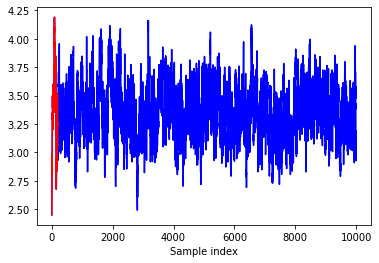

In [10]:
plt.plot(lam, 'b')
plt.plot(lam[:burnin], 'r')
plt.xlabel('Sample index')
plt.show()

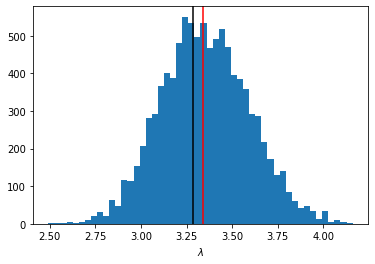

In [11]:
plt.hist(lam[burnin:], bins=50)
plt.axvline(x=np.mean(x), color='r', label='Mean of $x$')
plt.axvline(x=lambda_actual, color='k', label='Actual $\lambda_1$')
plt.xlabel('$\lambda$')
plt.show()